In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from plotly import graph_objs as go
import tqdm

In [44]:
### make our test function ###
class Func:
    curr_x = -1
    curr_y = -1
    def __init__(self, A, B):
        self.a = 1 - 3.0 * B + 3.0 * A
        self.b = 3.0 * B - 6 * A
        self.c = 3 * A
        self.d = -1.0
    def foo(self, x, y):
        self.d = -min(math.sqrt(x ** 2 + y ** 2), 1)
        t = 0.5
        for i in range(1,6):
            t = t - (self.a * t ** 3 + self.b * t ** 2 + self.c * t + self.d) / (3 * self.a * t ** 2 + 2 * self.b * t + self.c)
        return (1 - t) ** 3 + 3 * (1 - t) ** 2 * t
    def foo_x(self, x):
        return self.foo(x, self.curr_y)
    def foo_y(self, y):
        return self.foo(self.curr_x, y)

class TestFunc:
    curr_x = -1
    curr_y = -1
    def __init__(self, A, B):
        self.a = 1 - 3.0 * B + 3.0 * A
        self.b = 3.0 * B - 6 * A
        self.c = 3 * A
        self.d = -1.0
    def foo(self, x, y):
        return math.sqrt(x**2 + y**2)*(math.sqrt(x**2 + y**2) - 0.5)*(math.sqrt(x**2 + y**2) - 1)
    def foo_x(self, x):
        return self.foo(x, self.curr_y)
    def foo_y(self, y):
        return self.foo(self.curr_x, y)

In [183]:
### contain curr error
error = -1.0
h = 10 ** (-8)
### gris step, and domain of fun
step = 10 ** (-2)
interaval_x = np.arange(-1, 1, step)
interaval_y = np.arange(-1, 1, step)

A = 10
B = -10
f = TestFunc(A, B)

In [184]:
### draw func

z = np.array([[f.foo(x, y) for y in interaval_y] for x in interaval_x])

# z2 = z1 + 1
# z3 = z1 - 1

fig = go.Figure(data=[go.Surface(z=z, x = interaval_x, y = interaval_y)])
fig.show()

Найдем вторые частные производные: 

Найдем вторые смешанные производные: 
$$f(x, y) - f(x + h, y) - f(x, y + h) + f(x + h, y + h) = 2f''_{xy}h^2 + O(h^3) \Rightarrow $$
$$2f''_{xy} = \Big(f(x, y) - f(x + h, y) - f(x, y + h) + f(x + h, y + h)\Big) / 2h^2 + O(h) $$

In [67]:
### send f and point where calc derr
def derivative_second_xx_or_yy(f, x):
    global error, h
    der_h = (f(x + h) + f(x - h) - 2 * f(x)) / (h ** 2)
    der_h2 = (f(x + h/2) + f(x - h/2) - 2 * f(x)) / ((h/2) ** 2)
    error = max(abs(der_h - der_h2) / (1 - 0.25), error)
    return der_h 

def derivative_second_xy(f, x, y):
    global error, h
    der_h = (f(x, y) - f(x + h, y) - f(x, y + h) + f(x + h, y + h)) / (2 * (h ** 2))
    der_h2 = (f(x, y) - f(x + h/2, y) - f(x, y + h/2) + f(x + h/2, y + h/2)) / (2 * ((h/2) ** 2))
    error = max(abs(der_h - der_h2) / (1 - 0.5), error)
    return der_h

Оценим погрешность погрешность каждого элемента как максимум погрешности всех элементов (переменная error). Также заметим, что смешанные производные вычисляются с первой степенью аппроксимации, а производные xx и yy  с второй точностью. Поэтому $$a_{11}\cdot a_{22} - a_{01}\cdot a_{10}$$

Вычисляем Гессиан, сравниваем его с ошибкой и если в этой точке значение Гессиана сравнимо с погрешностью, отмечаем точку.

In [169]:
special_points_x = []
special_points_y = []
bugle_x = []
bugle_y = []
unbugle_x = []
unbugle_y = []

def Hessian(f, x, y):
    global error
    hess = [[0,0], [0,0]]
    f.curr_y = y
    hess[0][0] = derivative_second_xx_or_yy(f.foo_x, x)

    f.curr_x = x
    hess[1][1] = derivative_second_xx_or_yy(f.foo_y, y)

    hess[0][1] = derivative_second_xy(f.foo, x, y)
    hess[1][0] = hess[0][1]
    error *= math.sqrt(2)
    return hess[0][0] * hess[1][1] - hess[0][1] ** 2


# f is object of Func
def checking_for_zero_hessian(f, interval_x, interval_y):
    #with tqdm.tqdm(total=len(interval_x) * len(interval_y)) as progress:
        global error
        for x in interval_x:
            for y in interval_y:
                hes = Hessian(f, x, y)
                if abs(hes) <= 2*error:
                    special_points_x.append(x)
                    special_points_y.append(y)  
                elif (hes > 0):
                    bugle_x.append(x)
                    bugle_y.append(y)
                else:
                    unbugle_x.append(x)
                    unbugle_y.append(y)
                error = -1.0
     #           progress.update(1)
                

In [129]:
checking_for_zero_hessian(f, interaval_x, interaval_y)

100%|██████████| 4000000/4000000 [07:16<00:00, 9155.43it/s] 


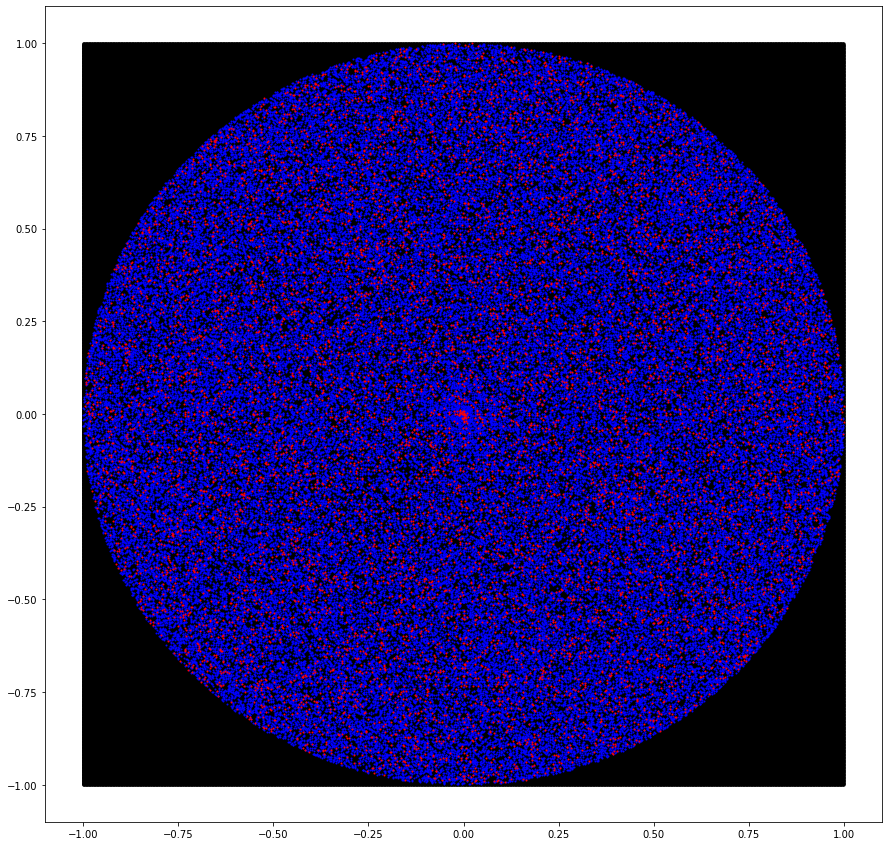

In [131]:
##make scatter of special points
plt.figure(figsize=(15,15))
plt.plot(special_points_x, special_points_y, 'o', color='black', markersize = 1);
plt.plot(bugle_x, bugle_y, 'o', color='b', markersize = 1);
plt.plot(unbugle_x, unbugle_y, 'o', color='r', markersize = 1);

100%|██████████| 5/5 [01:26<00:00, 17.22s/it]


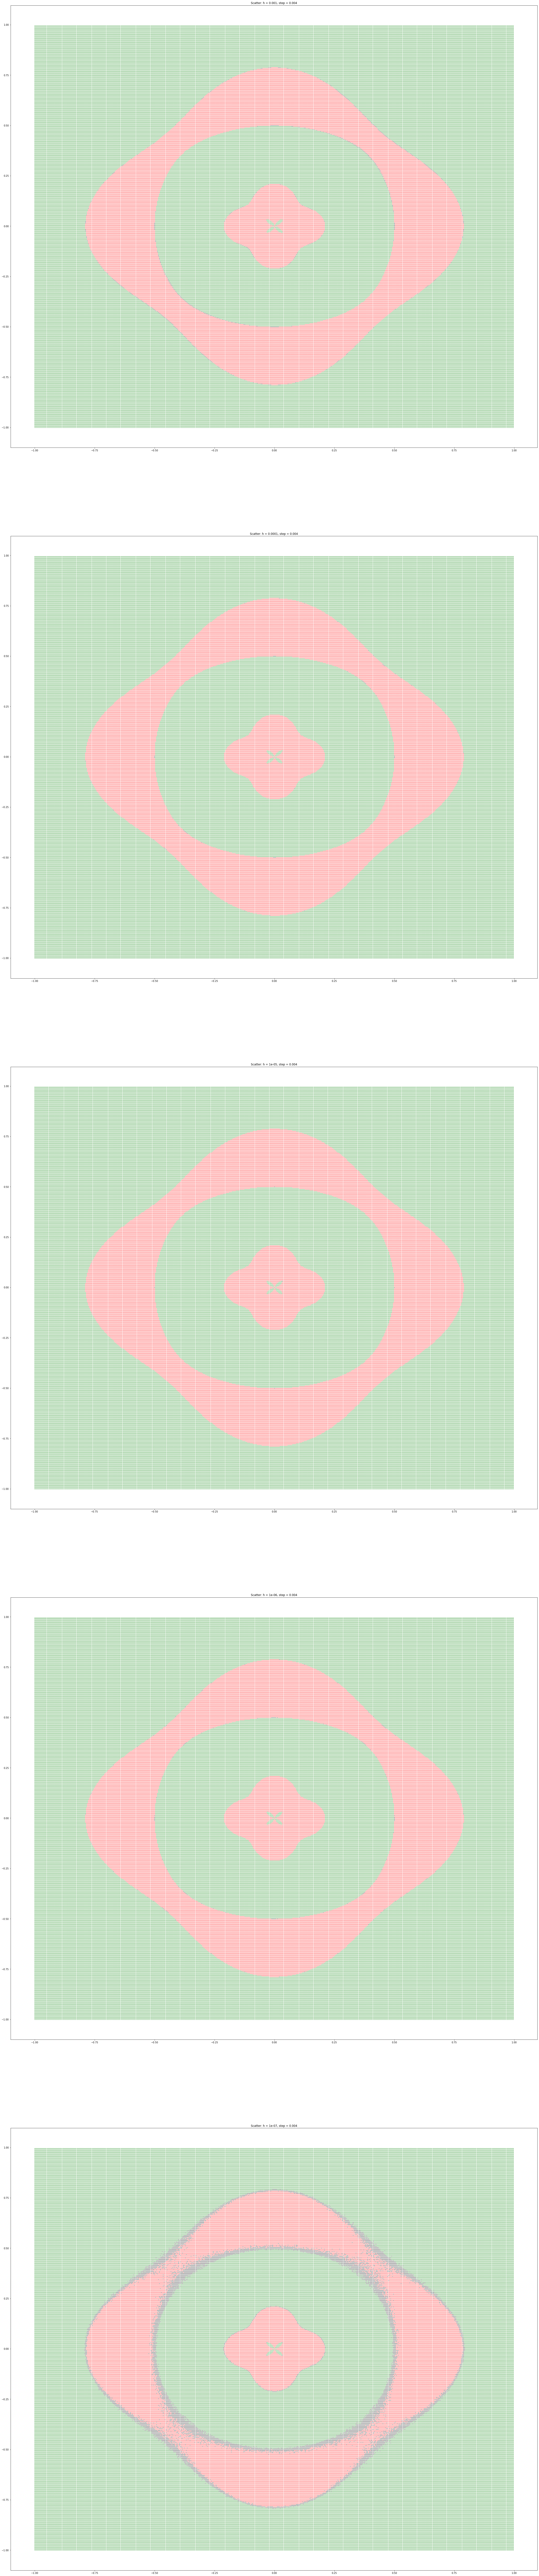

In [181]:
numH = 5
numStep = 3

fig, ax = plt.subplots(
    nrows=numH, ncols=1,
    figsize=(40, 40*numH)
)
with tqdm.tqdm(total=numH) as prog:
    for i in range(numH):
        error = -1.0
        h = 10 ** (-i - 3)
        ### gris step, and domain of fun
        step = 0.004
        interaval_x = np.arange(-1, 1, step)
        interaval_y = np.arange(-1, 1, step)
        special_points_x = []
        special_points_y = []
        bugle_x = []
        bugle_y = []
        unbugle_x = []
        unbugle_y = []
        checking_for_zero_hessian(f, interaval_x, interaval_y)
        prog.update(1)

        ax[i].scatter(special_points_x, special_points_y, s = 1, c='black', marker='o')
        ax[i].scatter(bugle_x, bugle_y, s = 1, c='g', marker='o')
        ax[i].scatter(unbugle_x, unbugle_y, s = 1, c='r', marker='o')
        ax[i].set_title('Scatter: h = ' + str(h) + ', step = ' + str(step))

# ax1.plot(special_points_x, special_points_y, marker='o', color='black', markersize = 1)
# ax1.plot(bugle_x, bugle_y, 'o', color='b', markersize = 1)
# ax1.plot(unbugle_x, unbugle_y, 'o', color='r', markersize = 1)
# ax1.set_title('Scatter: $x$ versus $y$')

fig.savefig('foo.png')
plt.show()

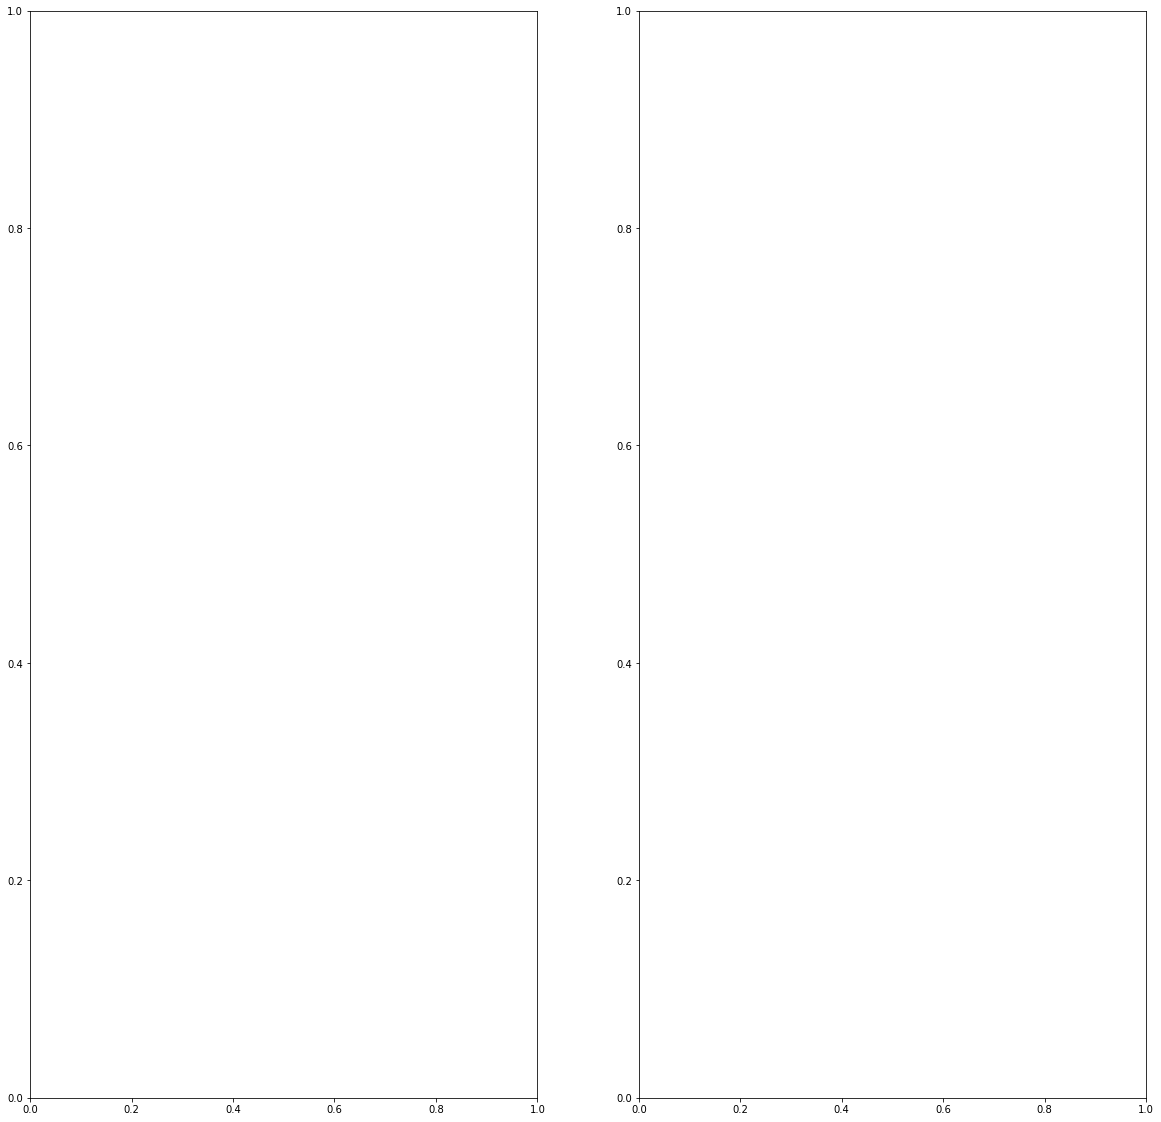

In [142]:
fig, a = plt.subplots(
    nrows=1, ncols=2,
    figsize=(20, 20)
)

# ax1.plot(special_points_x, special_points_y, marker='o', color='black', markersize = 1)
# ax1.plot(bugle_x, bugle_y, 'o', color='b', markersize = 1)
# ax1.plot(unbugle_x, unbugle_y, 'o', color='r', markersize = 1)
# ax1.set_title('Scatter: $x$ versus $y$')

fig.savefig('foo.png')
plt.show()